In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylops
from scipy.signal import butter, filtfilt
from numpy.linalg import inv
import warnings
import scienceplots

warnings.filterwarnings("ignore")

plt.style.use(["bmh", "science", "notebook", "grid"])
PRIMARY = "#0072b2"
PRIMARY_DARK = "navy"
SECONDARY = "#a60628"
SECONDARY_DARK = "#79011B"
TERCIARY = "firebrick"
ALTERNATIVE = "darkorange"
TEXT_COLOR = "#212121"
plt.rc("font", family="Arial")
FONT_SIZE = 19
LABEL_SIZE = 16

## Preparação

In [5]:
data_amp = np.load("Uncompressed/amplitude.npy")
data_imp = np.load("Uncompressed/impedance.npy")

print(f" data shape {np.shape(data_amp)}")
print(f" data shape {np.shape(data_imp)}")

 data shape (256, 256, 256)
 data shape (256, 256, 256)


In [6]:
"""
Fazendo a freq de baixa. Aqui, não é necessário passar por todo o processo de amarração de poço, visto que é um dados sintético. Nesse caso, é apenas passado um filtro passa-baixa para simular os dados de baixa frequência. Tanto na que vai ser usada para a inversão, tanto na original para comparar posteriormente.
"""

cutoff_back = 6 # cutoff frequency
cutoff_30hz = 30 # cutoff frequency
fs = 128 # Frequency sample

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a


def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

imp_30hz = butter_lowpass_filtfilt(data_imp, cutoff_30hz, fs, order=5)
imp_background = butter_lowpass_filtfilt(data_imp, cutoff_back, fs, order=5)

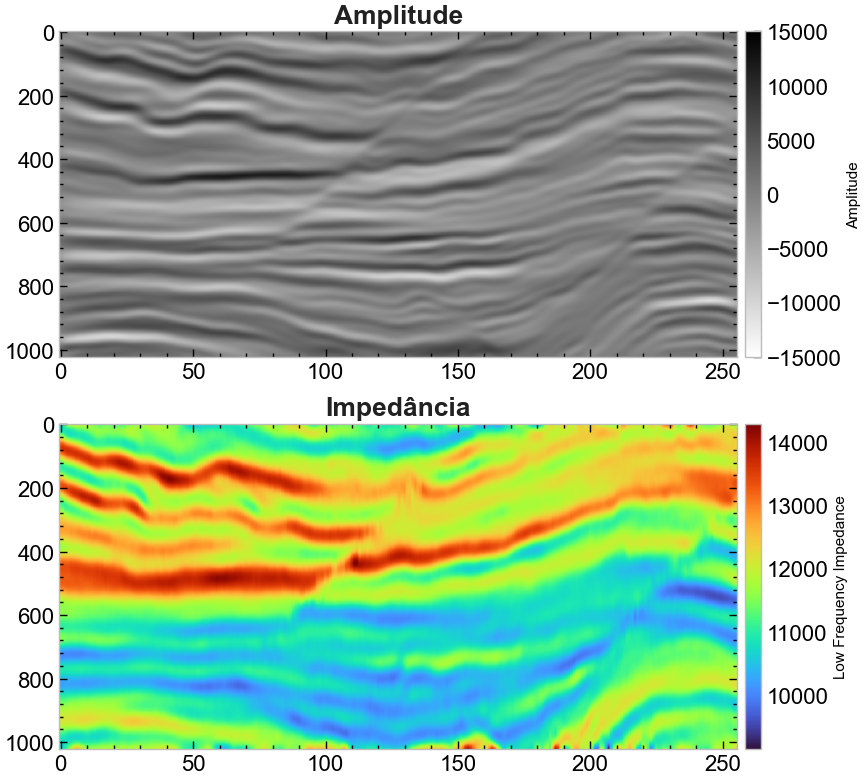

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 200

c = axs[0].imshow(
    data_amp[SECTION, :, :].T, cmap="gray_r", aspect="auto", vmin=-15000, vmax=15000
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Amplitude", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title("Amplitude", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)

c = axs[1].imshow(
    imp_background[SECTION, :, :].T,
    cmap="turbo",
    aspect="auto",
    # vmin=8000,
    # vmax=14000
)

cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Low Frequency Impedance", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title("Impedância", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
plt.show()

## Wavelets

### Ricker

In [8]:
def ricker(peak_freq, samples, dt):
    """
    retorna a wavelet de Ricker e sua FFT
    """
    # Array do tempo
    t = np.arange(samples) * (dt / 1000)
    t = np.concatenate((np.flipud(-t[1:]), t), axis=0)

    # Cálculo da wavelet de Ricker
    pi2_f2_t2 = (np.pi**2) * (peak_freq**2) * (t**2)
    ricker = (1.0 - 2.0 * pi2_f2_t2) * np.exp(-pi2_f2_t2)
    
    # Cálculo da FFT
    freqs = np.fft.rfftfreq(t.shape[0], d=dt / 1000)
    fft = np.abs(np.fft.rfft(ricker))
    fft = fft / np.max(fft)

    return t, ricker, freqs, fft
    
# Parâmetros
PKFQ = 30
DT = 4

# Chamada da função unificada
twlet, wlet, freqs, fft = ricker(peak_freq=PKFQ, samples=36, dt=DT)
print(twlet[0], wlet[0], freqs[0], fft[0])

-0.14 -8.511134110475258e-74 0.0 0.0


### Butterworth

In [9]:
from scipy import signal

def butter_wavelet_with_fft(freq_hi, freq_low, samples, dt):
    # Calcular array de tempo
    t = np.arange(samples) * (dt / 1000)
    t = np.concatenate((np.flipud(-t[1:]), t), axis=0)

    # Criar sinal de impulso
    imp = signal.unit_impulse(t.shape[0], "mid")

    # Aplicar filtro Butterworth passa-alta
    fs = 1000 * (1 / dt)
    b, a = signal.butter(4, freq_hi, fs=fs)
    response_zp = signal.filtfilt(b, a, imp)

    # Aplicar filtro Butterworth passa-baixa
    low_b, low_a = signal.butter(2, freq_low, "hp", fs=fs)
    butter_wvlt = signal.filtfilt(low_b, low_a, response_zp)

    # Normalizar a wavelet
    butter_wvlt = butter_wvlt / np.max(butter_wvlt)

    # Calcular a FFT
    freqs = np.fft.rfftfreq(t.shape[0], d=dt / 1000)
    fft = np.abs(np.fft.rfft(butter_wvlt))
    fft = fft / np.max(fft)

    return t, butter_wvlt, freqs, fft

# Parâmetros
FREQHI = 55
FREQLOW = 10
SAMPLESB = 36
DTB = 4

# Chamada da função unificada
twlet_b, wlet_b, freqs_b, fft_b = butter_wavelet_with_fft(
    freq_hi=FREQHI, freq_low=FREQLOW, samples=SAMPLESB, dt=DTB
)

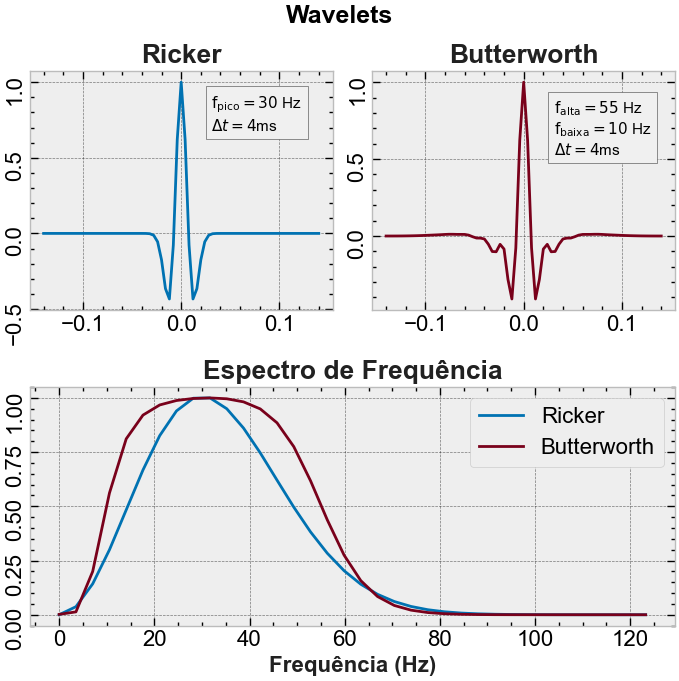

In [10]:
plt.figure(figsize=(7, 7))

textstr1 = "\n".join(
    (r"$\text{f}_{\text{pico}}=%d$ Hz" % (PKFQ), r"$\Delta t=%d$ms" % (DT))
)

textstr2 = "\n".join(
    (
        r"$\text{f}_{\text{alta}}=%d$ Hz" % (FREQHI),
        r"$\text{f}_{\text{baixa}}=%d$ Hz" % (FREQLOW),
        r"$\Delta t=%d$ms" % (DTB),
    )
)

plt.suptitle("Wavelets", fontsize=18, fontweight="bold")

plt.subplot2grid((2, 2), (0, 0))
plt.plot(twlet, wlet, color=PRIMARY)
plt.tick_params(axis="y", labelsize=LABEL_SIZE, rotation=90)
plt.title("Ricker", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")
plt.text(
    0.60,
    0.75,
    textstr1,
    fontsize=11,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.subplot2grid((2, 2), (0, 1))
plt.plot(twlet_b, wlet_b, color=SECONDARY_DARK)
plt.tick_params(axis="y", labelsize=LABEL_SIZE, rotation=90)
plt.title("Butterworth", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")
plt.text(
    0.60,
    0.65,
    textstr2,
    fontsize=11,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.tick_params(axis="y", labelsize=LABEL_SIZE, rotation=90)
plt.plot(freqs, fft, color=PRIMARY, label="Ricker")
plt.title(
    "Espectro de Frequência", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold"
)
plt.plot(freqs_b, fft_b, color=SECONDARY_DARK, label="Butterworth")
plt.xlabel("Frequência (Hz)", color=TEXT_COLOR, fontweight="bold")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig("Figures/grid_wavelets.png", dpi=1000, bbox_inches="tight")
plt.savefig("Figures/grid_wavelets.svg", dpi=1000, bbox_inches="tight")
plt.show()

## Inversão Maximum Likelihood

Utilizando mínimos quadrados

In [14]:
# parâmetros do operador
nz, nx, ny = data_amp.shape


poststack_ricker = pylops.avo.poststack.PoststackLinearModelling(
    wlet / 2, nt0=nz, spatdims=1, explicit=True
)

poststack_butter = pylops.avo.poststack.PoststackLinearModelling(
    wlet_b / 2, nt0=nz, spatdims=1, explicit=True
)

In [15]:
import numpy as np
import pylops
from tqdm import tqdm


def inverting_ricker_butter(amplitude, imp_back, impedance, PPop, PPop_b):
    nx, ny, nz = amplitude.shape

    inv_imp_ricker = np.zeros_like(impedance)
    inv_imp_butter = np.zeros_like(impedance)

    for ix, iy in tqdm(np.ndindex(nx, ny), desc="Processing traces"):
        seismic_trace = amplitude[ix, iy, :]
        impedance_trace = imp_back[ix, iy, :]

        inverted_impedance_trace_ricker = (
            pylops.optimization.leastsquares.normal_equations_inversion(
                Op=PPop,
                y=seismic_trace.flatten(),
                Regs=[],
                epsI=5e-1,
                x0=impedance_trace.flatten(),
                engine="scipy",
                **dict(maxiter=1000)
            )[0]
        )

        inv_imp_ricker[ix, iy, :] = inverted_impedance_trace_ricker.reshape(nz)

        inverted_impedance_section_butter = (
            pylops.optimization.leastsquares.normal_equations_inversion(
                Op=PPop_b,
                y=seismic_trace.flatten(),
                Regs=[],
                epsI=5e-1,
                x0=impedance_trace.flatten(),
                engine="scipy",
                **dict(maxiter=1000)
            )[0]
        )

        inv_imp_butter[ix, iy, :] = inverted_impedance_section_butter.reshape(nz)

    inverted_impedance_final_ricker = inv_imp_ricker + imp_back
    inverted_impedance_final_butter = inv_imp_butter + imp_back

    return inverted_impedance_final_ricker, inverted_impedance_final_butter

ml_inverted_impedance_final_ricker, ml_inverted_impedance_final_butter = inverting_ricker_butter(
    data_amp, imp_background, data_imp, poststack_ricker, poststack_butter
)

Processing traces: 65536it [02:02, 536.64it/s] 


##### Resíduo

In [15]:
ml_residuo = ml_inverted_impedance_final_ricker - ml_inverted_impedance_final_butter
ml_residuo_ricker = imp_30hz - ml_inverted_impedance_final_ricker
ml_residuo_butter = imp_30hz - ml_inverted_impedance_final_butter

## Visualização

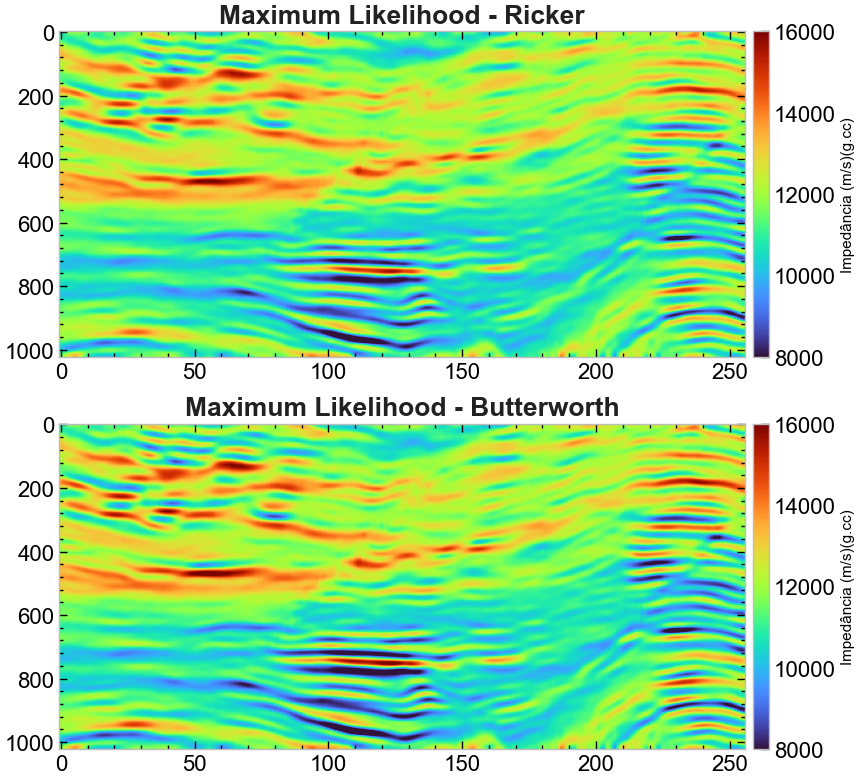

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 200

c = axs[0].imshow(
    ml_inverted_impedance_final_ricker[SECTION, :, :].T, cmap="turbo", aspect="auto", vmin=8000, vmax=16000
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title("Maximum Likelihood - Ricker", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)

c = axs[1].imshow(
    ml_inverted_impedance_final_butter[SECTION, :, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=8000, vmax=16000
)
cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title("Maximum Likelihood - Butterworth", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
plt.show()

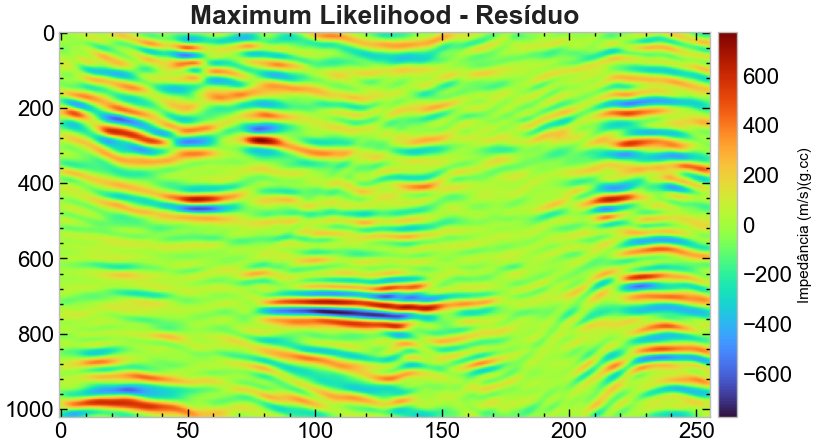

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

SECTION = 200

c = axs.imshow(
    ml_residuo[SECTION, :, :].T, cmap="turbo", aspect="auto"
)
cbar = fig.colorbar(c, ax=axs, pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs.set_title("Maximum Likelihood - Resíduo", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs.set_yticklabels(
    [str(int(tick) * 4) for tick in axs.get_yticks()]
)  # Altera os rótulos do eixo y
axs.tick_params(axis="both", labelsize=LABEL_SIZE)
axs.grid(False)

## Inversão Sparse Spike

Utilizando IRLS

##### Ricker

In [18]:
from pylops.optimization.sparsity import irls

ss_inverted_impedance_ricker = np.zeros_like(data_imp)

for iy in range(ny):
    seismic_section_r = data_amp[:, :, iy]
    impedance_section_r = imp_background[:, :, iy]
    
    inverted_ricker, nouter = (
        irls(
            Op = poststack_ricker,
            y=seismic_section_r.flatten(),
            epsI=1e-1,  # tikhonov
            x0=impedance_section_r.flatten(),  # modelo inicial
            nouter=5,
            tolIRLS=1e-1,
            # **dict(maxiter=1000)
        ) # Esse índice é necessário para pegar apenas o resultado
    )
    
    # Colocar o resultado de volta no volume 3D de impedâncias
    ss_inverted_impedance_ricker[:, :, iy] = inverted_ricker.reshape(
        nz, nx
    )
    
ss_inverted_impedance_final_ricker = ss_inverted_impedance_ricker #+ imp_background

##### Butterworth

In [19]:
from pylops.optimization.sparsity import irls

ss_inverted_impedance_butter = np.zeros_like(data_imp)

for iy in range(ny):
    seismic_section_b = data_amp[:, :, iy]
    impedance_section_b = imp_background[:, :, iy]
    
    inverted_butter, nouter = (
        irls(
            Op = poststack_butter,
            y=seismic_section_b.flatten(),
            epsI=1e-1,  # tikhonov
            x0=impedance_section_b.flatten(),  # modelo inicial
            nouter=5,
            tolIRLS=1e-1,
            # **dict(maxiter=1000)
        ) # Esse índice é necessário para pegar apenas o resultado
    )
    
    # Colocar o resultado de volta no volume 3D de impedâncias
    ss_inverted_impedance_butter[:, :, iy] = inverted_butter.reshape(
        nz, nx
    )
    
ss_inverted_impedance_final_butter = ss_inverted_impedance_butter #+ imp_background

In [20]:
ss_residuo = ss_inverted_impedance_final_ricker - ss_inverted_impedance_final_butter
ss_residuo_ricker = imp_30hz - ss_inverted_impedance_final_ricker
ss_residuo_butter = imp_30hz - ss_inverted_impedance_final_butter

# Visualização

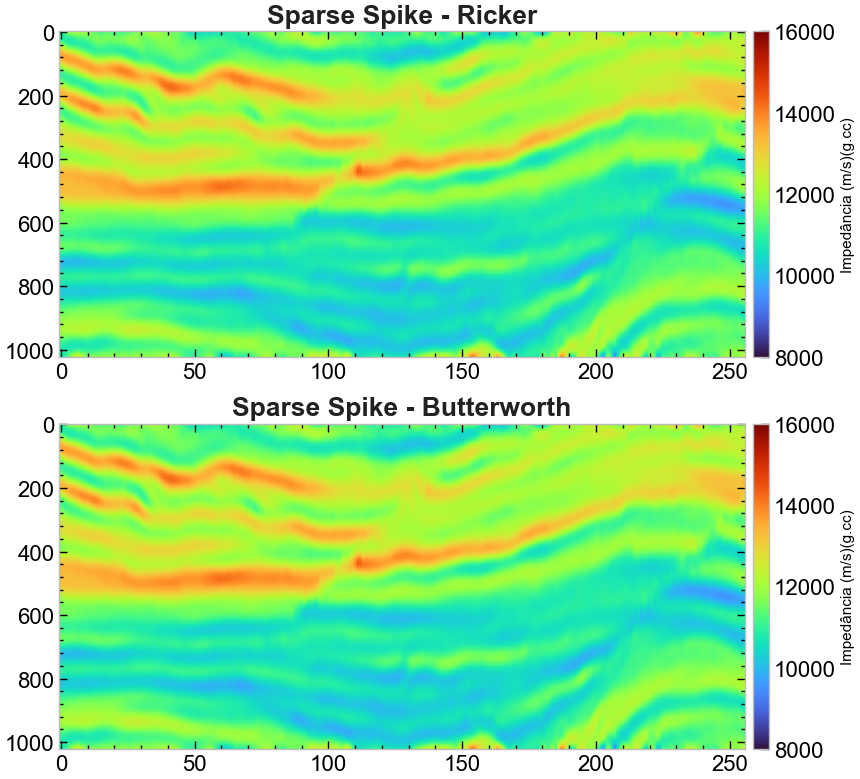

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 200

c = axs[0].imshow(
    ss_inverted_impedance_final_ricker[SECTION, :, :].T, cmap="turbo", aspect="auto", vmin=8000, vmax=16000
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title("Sparse Spike - Ricker", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)

c = axs[1].imshow(
    ss_inverted_impedance_final_butter[SECTION, :, :].T,
    cmap="turbo",
    aspect="auto", vmin=8000, vmax=16000
)
cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title("Sparse Spike - Butterworth", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
plt.show()

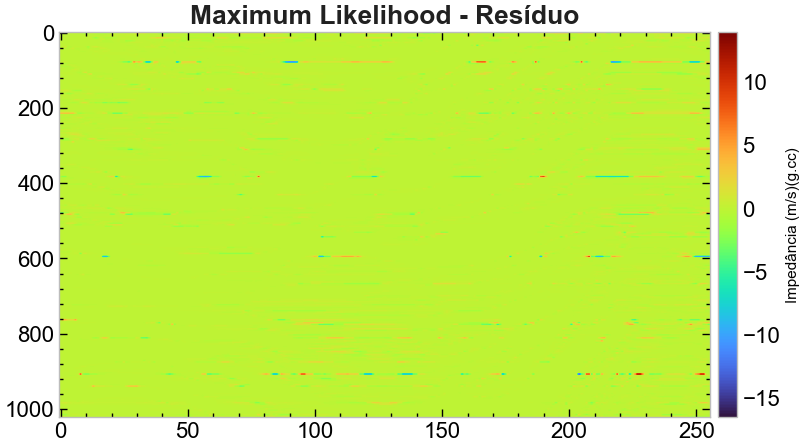

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

SECTION = 200

c = axs.imshow(
    ss_residuo[SECTION, :, :].T, cmap="turbo", aspect="auto"
)
cbar = fig.colorbar(c, ax=axs, pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs.set_title("Maximum Likelihood - Resíduo", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
axs.set_yticklabels(
    [str(int(tick) * 4) for tick in axs.get_yticks()]
)  # Altera os rótulos do eixo y
axs.tick_params(axis="both", labelsize=LABEL_SIZE)
axs.grid(False)